# Final Project for UIS CS570: Data Science Essentials

Train Naive Bayes model to classify future incoming emails as Priority Inbox or Regular Inbox based on previous user behavior

Steps:
> 1. Collect, Clean and Prepare data from Microsoft Outlook
> 2. Convert email to sparse matrix of TFIDF vectors
> 3. Train Naive Bayes Classifier
> 4. Measure Recall/Precision - ROC AUC Score
> 5. Try Model with examples

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read In Data from Excel File
df = pd.read_excel("email_inbox_data_cleaned.xlsx", sep='\t',
                   names=["Read", "Subject", "Body", "From: Name", 
                        "From: Address", "From: Type", "To: Name", "To: Address", "To: Type", 
                        "CC: Name", "CC: Address", "CC: Type", "BCC: Name", "BCC: Address", "BCC: Type", 
                        "Billing Information", "Categories", "Importance", "Mileage", "Sensitivity"])

In [3]:
# Perform Initial EDA
df.head(3)

,Read,Subject,Body,From: Name,From: Address,From: Type,To: Name,To: Address,To: Type,CC: Name,CC: Address,CC: Type,BCC: Name,BCC: Address,BCC: Type,Billing Information,Categories,Importance,Mileage,Sensitivity
0,1,Reminder - RSVP & Apply for Swiss Trek!,Login <http://clubs.london.edu/click?uid=54489...,cg-mailer@london.edu,cg-mailer@london.edu,SMTP,Dan Lee,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
1,1,Deep learning on Udacity,https://techcrunch.com/2017/01/13/udacity-laun...,Sandeep Anantharaman,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Dan Lee,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
2,0,Chinese New Year Dim Sum Feast!,Login <http://clubs.london.edu/click?uid=eb36b...,cg-mailer@london.edu,cg-mailer@london.edu,SMTP,Dan Lee,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal


In [4]:
df.describe

<bound method NDFrame.describe of       Read                                            Subject  \
0        1            Reminder - RSVP & Apply for Swiss Trek!   
1        1                           Deep learning on Udacity   
2        0                    Chinese New Year Dim Sum Feast!   
3        0  Heena Rabadiya (E488 A SPR17 Social Media and ...   
4        0  5D Leadership | Muhammed Yunus on thinking opp...   
5        1                               RE: VA CHEQUE REFUND   
6        1                       MIBC CV / Interview Coaching   
7        1  Updated Invitation: Info Call @ Wed Jan 18, 20...   
8        1  Invitation: Info Call @ Wed Jan 18, 2017 6pm -...   
9        1                                   VA CHEQUE REFUND   
10       0                  Change of Deputy Dean, Programmes   
11       0                "Welcome back Careers Q&A” - 23 Jan   
12       0           January Newsletter: Events + Internships   
13       0           January Newsletter: Events + Intern

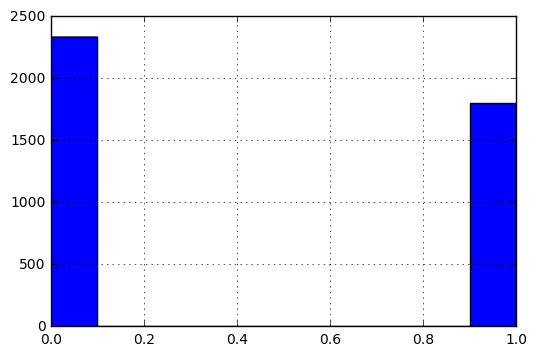

In [5]:
df.Read.hist()

In [6]:
# Prepare Data for Modelling
## Drop All Features other than Read, Subject and Body
## Separate Read, the dependent variable, from Subject and Body, the input features
temp = df[['Read', 'Subject', 'Body']]
temp['text'] = df.Subject + " " + df.Body
temp = temp[['Read', 'text']]
print(temp[temp.text.isnull() == True])
temp = temp[temp.text.isnull() == False] # deletes NaN rows otherwise causes error in TFIDF Vectorizer
print(temp.shape)
X = temp.text
y = temp.Read
X.head()

      Read text
212      1  NaN
1214     1  NaN
1438     0  NaN
2230     1  NaN
2992     1  NaN
(4132, 2)


C:\Users\leeda\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    Reminder - RSVP & Apply for Swiss Trek! Login ...
1    Deep learning on Udacity https://techcrunch.co...
2    Chinese New Year Dim Sum Feast! Login <http://...
3    Heena Rabadiya (E488 A SPR17 Social Media and ...
4    5D Leadership | Muhammed Yunus on thinking opp...
Name: text, dtype: object

In [7]:
# TF-IDF Vectorizer: Convert txt to a sparse matrix of TFIDF vectors
stopset = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopset)
X = vectorizer.fit_transform(X)
print(X.shape)
print(y.shape)

(4132, 129674)
(4132,)


In [8]:
# Test Train Split & Train Naive Bayes Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

AUC/C-stat:  0.795311606632


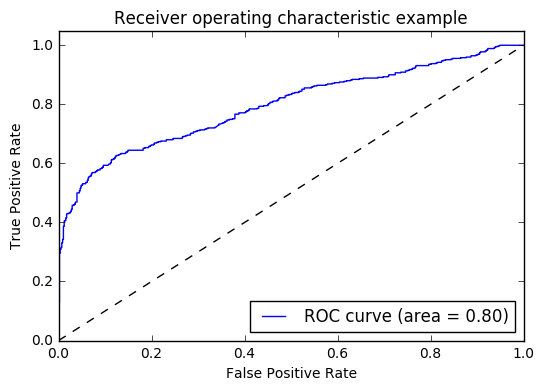

In [9]:
# Model Accuracy
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print ("AUC/C-stat: ", roc)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
email_text_array = np.array(["Final Tickets! Get Inspired at TEDxLondonBusinessSchool on Friday, May 12 Login - If you cannot see this e-mail, go to this page 16 Ideas Worth Spreading | 400 bright minds | Iconic London Location Friday, May 12 With just two days left till the 7th TEDxLondonBusinessSchool, we are excited to present our final line-up of speakers. Each person has a unique idea worth sharing and we invite you to join us on Friday to hear stories of critical choices made in critical moments of time. Don't wait anymore! Buy your tickets now using the code LBSLOVE for a special 10% off! Hungry for more? Visit www.tedxlbs.com TEDxLBS London Business School Email sent by Surekha Rao to danl.mba2017@london.edu Unsubscribe from TEDxLBS  Email powered by  The CampusGroups offices are located at 902 Broadway, New York, NY 10010"])
                            
email_text_vector = vectorizer.transform(email_text_array)
                            
print("Read: ", clf.predict(email_text_vector))

Read:  [0]


In [11]:
email_text_array = np.array(["MBA2017 Global Business Experience: Hong Kong Grade Breakdown"])
                            
email_text_vector = vectorizer.transform(email_text_array)
                            
print("Read: ", clf.predict(email_text_vector))

Read:  [1]


In [13]:
email_text_array = np.array(["LATAM SUNDOWNERS!! LBS #1 campus wide event. Your one occasion to connect with LBS' unique community! Thursday 11th May LATAM Club does Sundowners! Have you heard of onzei•dei•mayow”? It's like Cinco de Mayo, but doesn't clash with MBAT and is a celebration of the whole LATAM community! Come celebrate Once de Mayo with us, and enjoy a couple of hours of the best LATAM cuisine (debatable), the best music (not-debatable) and the best company (fact). Mi casa es su casa ---------- See you on Thursday evening! If Jack ‘Judas’ Williamson can party again after the weekend, then so can you… And in case you were wondering what a tortilla sounds like on a record player, wonder no more! https://www.facebook.com/tastelessgentlemen/videos/1085364858188575/ 	Sundowners is a LBS community event, with rules to abide by: 1. You must have your LBS IDs 2. Alcohol must stay within Nash/Front Lawn. Take it further, and it'll be taken from you. 3. Smoking is not allowed, except on the Front Lawn, not near our beautiful buildings. Please dispose of your butts. 4. Recycle your cups. 5. Please leave when asked - we risk losing our license if we don't end on time. 6. Respect other students, staff and the crew - they are volunteers after all! Feedback,complaints, comments & kudos: sundowners@london.edu Copyright © 2016, Sundowners, All rights reserved."])
                            
email_text_vector = vectorizer.transform(email_text_array)
                            
print("Read: ", clf.predict(email_text_vector))

Read:  [0]


In [12]:
email_text_array = np.array(["Another One - Amazon Advertising Hi Dan, I met Lars Hirsch for coffee today to learn more about his advertising business. His team is rapidly growing and he is looking for product managers with data science backgrounds. See, https://www.linkedin.com/in/lrhirsch/. I did not know Amazon had an advertising business—who knew!?! Anyways, it is super exciting. I did a quick search and found this article that is pretty good: •	https://www.bloomberg.com/gadfly/articles/2017-01-30/amazon-turns-next-to-200-billion-advertising-industry And this is the public company website describing the service: •	https://services.amazon.com/services/sponsored-products-overview.htm Lars has not posted his reqs yet. But here are a couple on the team that should give you an idea of what they do: •	https://www.amazon.jobs/jobs/499641 •	https://www.amazon.jobs/jobs/524972 •	https://www.amazon.jobs/jobs/528223 Would you be open to talking with him over the phone sometime? Thanks, Ray"])
                            
email_text_vector = vectorizer.transform(email_text_array)
                            
print("Read: ", clf.predict(email_text_vector))

Read:  [1]


In [14]:
email_text_array = np.array(["Military in Business Club Leadership 2017/18 Login - If you cannot see this e-mail, go to this page Dear Military in Business Club Members, We are pleased to announce the following new leadership team: Co-President: Will Carver Co-President: Eli Khrapko Treasurer: Kevin Davis Please join us in congratulating them and wishing them the best of luck with the coming year. Kind regards, James Scott-Barrett Tonmoy Dutta Roy Military in Business Club London Business School Email sent by James Scott-Barrett to danl.mba2017@london.edu Unsubscribe from Military in Business Club Email powered by The CampusGroups offices are located at 902 Broadway, New York, NY 10010"])
                            
email_text_vector = vectorizer.transform(email_text_array)
                            
print("Read: ", clf.predict(email_text_vector))

Read:  [0]


In [15]:
email_text_array = np.array(["Student Association Bulletin #27 2017  As the end of the academic year inches closer, it is time to recognize good deeds!  Hey LBS! So…. We hate to address the elephant in the room, but yeah the academic year is almost over now. Much quicker than we anticipated huh? And some of us made it this far only because of those good Samaritans who showed up and took it upon themselves to push us ahead. So, let us take the time to recognize and appreciate the efforts of those who made a positive impact to the community, shall we?    In this week's bulletin, we bring you:  Attached to the bulletin is a summary of each finalist and their nomination.  Please join us in thanking all 10 finalists for their contributions. They will now be invited to dinner next week with Senior Bain & Company leaders at the Dean's house, where the overall winner for 2017 will be revealed! STUDENT AWARDS 2017 – NOMINATIONS OPEN The annual Student Awards celebrate 15 - 20 students that have made an exceptional contribution or impact, either on a programme or the community as a whole.  We invite you to nominate any students that you feel have really made a difference. Nominate here - the closing date for round one is 15 May.  The nomination process will take place in three stages: •	Collation of nominations (currently taking place). Quality of submissions is particularly important at this stage. •	On Thursday 18 May we will share the long-list of nominees and give people the opportunity to vote for the students they feel have had the most impact. •	In June, the nominations will be reviewed by a judging panel of senior School administrators and the Student Association president. Students will be selected based on quantity and quality of nominations and other evidence of impact. Nominations and voting are open to everyone in the School community - students, staff, faculty and alumni. Only graduating students (including Sloan 2016s) are eligible to receive an award. The winners will be announced and invited to receive their award during the Student Celebration Evening on Wednesday 12 July. Please @Jon Conradi if you have any queries. ANNUAL GENERAL MEETING – YOU ARE INVITED Hello there! Annual General Meeting (AGM) would be the place where we report what happened during the year and SA’s plans for the future. To make it even more exciting, we will present our financial results for the year and propose changes to the SA Constitution.What’s that? You love going through financial results and discussing constitutional changes? So do we! Here’s the deal, we need a quorum of at least 50 students to pass what we believe are essential amendments to safeguard interests of the student community. And we cannot do it without some support from you!Rumour has it, there will be certain extrinsic incentives for the ones who show up! We are not saying it has anything to do with Windsor.  SAMMY OFER CENTRE SURVEYLondon Business School is committed to building a healthy and sustainable environment for students, faculty and staff. As part of the planning conditions for Sammy Ofer Centre, the School is required to prepare and commit to a travel plan. Completing this survey will help the school establish current travel patterns and understand the potential for proposed measures in the plan. OH!! And before we forget, if you include your name and email; you will be entered into a draw to receive £50 TFL Oyster top up. Woot!Questions? We love questions! Shoot them our way at sa@london.edu!Much Love!Your SA 	 	 "]) 
                             
email_text_vector = vectorizer.transform(email_text_array)
                            
print("Read: ", clf.predict(email_text_vector))

Read:  [1]
